In [12]:
import datajoint as dj
import numpy as np

# Define tables

In [15]:
schema = dj.Schema("experiment")

In [16]:
@schema
class Subject(dj.Manual):
    definition = """
    subject_name: varchar(16)
    ---
    sex: enum('F', 'M', 'U')
    """

In [17]:
@schema
class Session(dj.Manual):
    definition = """
    -> Subject
    session_id: int
    """

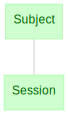

In [18]:
dj.Diagram(schema)

# Insert

In [19]:
Subject()

subject_name,sex


In [20]:
Subject.insert1({'subject_name': 'bob', 'sex': 'M'})

In [21]:
Subject()

subject_name,sex
bob,M


In [22]:
subject_list = [
    {'subject_name': 'alice', 'sex': 'F'},
    {'subject_name': 'anne', 'sex': 'F'}
]
Subject.insert(subject_list)

In [23]:
Subject()

subject_name,sex
alice,F
anne,F
bob,M


In [24]:
session_list = [
    {'subject_name': 'bob', 'session_id': 1},
    {'subject_name': 'bob', 'session_id': 2}
]
Session.insert(session_list)

In [25]:
Session()

subject_name,session_id
bob,1
bob,2


# Table with computation

In [26]:
@schema
class Param(dj.Lookup):
    definition = """
    param_id: int
    ---
    multiplier: int
    """    

In [27]:
@schema
class Analysis(dj.Computed):
    definition = """
    -> Session
    -> Param
    ---
    result: longblob
    """
    
    def make(self, key):
        # print status
        print(f"Working on session_id {key['session_id']} and param_id {key['param_id']}")
        
        # retrieve data from upstream
        session_id = (Session & key).fetch1('session_id')
        multiplier_val = (Param & key).fetch1('multiplier')
        
        # perform computation
        result = np.ones(10) * session_id * multiplier_val
        
        # store the results
        key['result'] = result
        self.insert1(key)

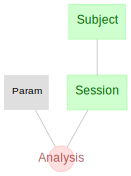

In [28]:
dj.Diagram(schema)

## Run the computation

In [29]:
Param()

param_id,multiplier


In [30]:
param_list = [
    {'param_id': 0, 'multiplier': 1},
    {'param_id': 1, 'multiplier': 16}
]
Param.insert(param_list)

In [31]:
Param()

param_id,multiplier
0,1
1,16


In [32]:
Analysis()

subject_name,session_id,param_id,result


In [33]:
Analysis.populate()

Working on session_id 2 and param_id 0
Working on session_id 1 and param_id 0
Working on session_id 2 and param_id 1
Working on session_id 1 and param_id 1


In [34]:
Analysis()

subject_name,session_id,param_id,result
bob,1,0,=BLOB=
bob,2,0,=BLOB=
bob,1,1,=BLOB=
bob,2,1,=BLOB=


In [35]:
# populate again - nothing new to be populated
Analysis.populate()

### Add new sessions and run analysis again

In [36]:
session_list = [
    {'subject_name': 'alice', 'session_id': 1},
    {'subject_name': 'anne', 'session_id': 2}
]
Session.insert(session_list)

In [37]:
# populate again
Analysis.populate()

Working on session_id 1 and param_id 1
Working on session_id 1 and param_id 0
Working on session_id 2 and param_id 1
Working on session_id 2 and param_id 0


In [38]:
Analysis()

subject_name,session_id,param_id,result
alice,1,0,=BLOB=
anne,2,0,=BLOB=
bob,1,0,=BLOB=
bob,2,0,=BLOB=
alice,1,1,=BLOB=
anne,2,1,=BLOB=
bob,1,1,=BLOB=
bob,2,1,=BLOB=


## Query

In [39]:
Session()

subject_name,session_id
alice,1
anne,2
bob,1
bob,2


In [40]:
Session * Subject

subject_name,session_id,sex
alice,1,F
anne,2,F
bob,1,M
bob,2,M


In [41]:
Session & 'session_id = 1'

subject_name,session_id
alice,1
bob,1


In [42]:
Session & 'subject_name = "bob"' & 'session_id = 1'

subject_name,session_id
bob,1


In [43]:
Session * Subject & 'subject_name = "bob"' & 'session_id = 1'

subject_name,session_id,sex
bob,1,M


# Fetch

In [44]:
Analysis()

subject_name,session_id,param_id,result
alice,1,0,=BLOB=
anne,2,0,=BLOB=
bob,1,0,=BLOB=
bob,2,0,=BLOB=
alice,1,1,=BLOB=
anne,2,1,=BLOB=
bob,1,1,=BLOB=
bob,2,1,=BLOB=


In [45]:
Analysis * Param & 'param_id = 1'

subject_name,session_id,param_id,result,multiplier
alice,1,1,=BLOB=,16
anne,2,1,=BLOB=,16
bob,1,1,=BLOB=,16
bob,2,1,=BLOB=,16


In [46]:
Analysis * Param & 'param_id = 1' & 'subject_name != "bob"'

subject_name,session_id,param_id,result,multiplier
alice,1,1,=BLOB=,16
anne,2,1,=BLOB=,16


In [47]:
query = Analysis * Param & 'param_id = 1' & 'subject_name != "bob"'

In [48]:
query.fetch()  # returns as record array

array([('alice', 1, 1, array([16., 16., 16., 16., 16., 16., 16., 16., 16., 16.]), 16),
       ('anne', 2, 1, array([32., 32., 32., 32., 32., 32., 32., 32., 32., 32.]), 16)],
      dtype=[('subject_name', 'O'), ('session_id', '<i8'), ('param_id', '<i8'), ('result', 'O'), ('multiplier', '<i8')])

In [49]:
query.fetch(as_dict=True)  # returns as list of dictionaries

[{'subject_name': 'alice',
  'session_id': 1,
  'param_id': 1,
  'result': array([16., 16., 16., 16., 16., 16., 16., 16., 16., 16.]),
  'multiplier': 16},
 {'subject_name': 'anne',
  'session_id': 2,
  'param_id': 1,
  'result': array([32., 32., 32., 32., 32., 32., 32., 32., 32., 32.]),
  'multiplier': 16}]

In [50]:
query.fetch(format='frame')  # returns as pandas dataframe

,,,result,multiplier
subject_name,session_id,param_id,,
alice,1,1,"[16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16....",16
anne,2,1,"[32.0, 32.0, 32.0, 32.0, 32.0, 32.0, 32.0, 32....",16


In [51]:
query.fetch('result')

array([array([16., 16., 16., 16., 16., 16., 16., 16., 16., 16.]),
       array([32., 32., 32., 32., 32., 32., 32., 32., 32., 32.])],
      dtype=object)

# Delete

In [52]:
Subject()

subject_name,sex
alice,F
anne,F
bob,M


In [53]:
Subject & 'subject_name = "anne"'

subject_name,sex
anne,F


In [ ]:
(Subject & 'subject_name = "anne"').delete()